In [1]:
import numpy as np
import torch
from torch import nn
import torch.distributions as dist
import scipy.stats as st
import pandas as pd
import math
import os
import arviz as az
%matplotlib inline

from networks import *

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {'text.usetex' : True,
          'font.size' : 9,
          'font.family' : 'lmodern'
          }
plt.rcParams.update(params) 
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import warnings
warnings.filterwarnings("ignore")

np.random.seed(37)
torch.manual_seed(37)

In [2]:
def plot(xi_samples, xi_data, y_data, j, title):
    #mpl.rcParams.update(mpl.rcParamsDefault)
    #plt.rcParams.update({'font.size': 9})
    
    width = 7.5/2
    height = width/1.6
    
    fig1 = plt.figure(figsize=(width, height))
    ax1 = fig1.add_subplot(1, 1, 1)
    # corresponding input field samples
    sigma = 1.5
    ax1.plot(x_gt.reshape(-1, 1), g(x_gt.reshape(-1, 1),xi_data[0].repeat(len(x_gt),1),sigma=sigma).detach().numpy(), '-.', color = 'black', label ='ground-truth')
    field_values = torch.zeros(xi_samples.shape[0], len(x_gt))
    for i in range(xi_samples.shape[0]):
        field_values[i] = g(x_gt.reshape(-1, 1),xi_samples[i].repeat(len(x_gt),1),sigma=sigma).flatten()
        if i <= 2:
            ax1.plot(x_gt.data.numpy(), field_values[i].data.numpy(), color='green') #label=i
    mean_field = torch.mean(field_values, dim=0) 
    ax1.plot(x_gt.data.numpy(), mean_field.data.numpy(),'-.', label='mean', color='red')
    low_field = torch.quantile(field_values, 0.025, dim=0) 
    high_field = torch.quantile(field_values, 0.975, dim=0) 
    ax1.fill_between(x_gt.data.numpy(), low_field.data.numpy(), high_field.data.numpy(), alpha = 0.5, color = 'cornflowerblue', label='predictive interval')
    plt.xlabel('$x$')
    plt.ylabel(r'$log(a(x,\xi))$', rotation=0)
    ax1.yaxis.set_label_coords(0.0, 1.05)
    #plt.legend(loc='upper right', frameon=False);
    sns.despine(trim=True)
    plt.tight_layout(pad=0.1)
    if save==True:
        plt.savefig(results_postprocessed_paper_dir+str(j)+'_cond_plot'+'.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    fig2 = plt.figure(figsize=(width, height))
    ax2 = fig2.add_subplot(1, 1, 1)
    # corresponding output field samples
    u_pred_gt = trajectories_from_parameters(xi_data[0])
    ax2.plot(x_gt.data.numpy(), u_pred_gt.flatten().data.numpy(),'-.', label='ground-truth', color='black')
    u_preds = torch.zeros((xi_samples.shape[0], len(x_gt)))
    for i in range(xi_samples.shape[0]):
        u_preds[i] = trajectories_from_parameters(xi_samples[i]).flatten()
        if i <= 2:
            ax2.plot(x_gt.data.numpy(), u_preds[i].data.numpy(), color='green') #label=i
    ax2.plot(x_ticks, y_data[0].data.numpy(), 'x', markersize = 8, markeredgewidth=2.0, color = 'black', label="sensor data "+r'$y$')
    mean_u_pred = torch.mean(u_preds, dim=0) 
    ax2.plot(x_gt.data.numpy(), mean_u_pred.data.numpy(),'-.', label='mean', color='red')
    low_u_pred = torch.quantile(u_preds, 0.025, dim=0) 
    high_u_pred = torch.quantile(u_preds, 0.975, dim=0) 
    ax2.fill_between(x_gt.data.numpy(), low_u_pred.data.numpy(), high_u_pred.data.numpy(), alpha = 0.5, color = 'cornflowerblue', label='predictive interval')
    plt.xlabel('$x$')
    plt.ylabel(r'$u(x,\xi)$', rotation=0)
    ax2.yaxis.set_label_coords(0.0, 1.05)
    plt.legend(loc='upper right', frameon=False);
    sns.despine(trim=True)
    plt.tight_layout(pad=0.1)
    if save==True:
        plt.savefig(results_postprocessed_paper_dir+str(j)+'_temp_plot'+'.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
        
    #plt.suptitle(title, fontsize=9)
    

def pair_plot(df, xi_data, j):
    #mpl.rcParams.update(mpl.rcParamsDefault)
    #plt.rcParams.update({'font.size': 9})
    
    fig, axes = plt.subplots(len(xi_data[0]), len(xi_data[0]), figsize = (14, 10), sharex="col", tight_layout=True)
    
    COLUMNS = list(df.columns)
    COLUMNS.remove('Sample type')

    for i in range(len(COLUMNS)):
        for k in range(len(COLUMNS)):
            
            # If this is the lower-triangule, add a scatterlpot for each group.
            if i > k:
                a = sns.scatterplot(data=df, x=COLUMNS[k], y=COLUMNS[i], 
                                      hue="Sample type", ax=axes[i, k], s=10, legend=False)
                a.set(xlabel=None)
                a.set(ylabel=None)
                axes[i, k].set_xlim([-5., 5.])
                
            # If this is the main diagonal, add kde plot
            if i == k:
                b = sns.kdeplot(data=df, x=COLUMNS[k], hue="Sample type",  common_norm=False, ax=axes[i, k])
                axes[i, k].axvline(x=xi_data[0][k], color = 'black', ls ='--')
                b.set(xlabel=None)
                b.set(ylabel=None)
                axes[i, k].set_xlim([-5., 5.])
                
                if k == 0:
                    sns.move_legend(b, "center right", bbox_to_anchor=(5,-1.25), title=None,frameon=True,)
                    #sns.move_legend(b, "lower center", bbox_to_anchor=(2.5, 1), ncol=3, title=None,frameon=True,)
                else:
                    axes[i, k].legend([],[], frameon=False)

            # If on the upper triangle
            if i < k:
                axes[i, k].remove()

    for i in range(len(COLUMNS)):
        k=0
        axes[i, k].set_ylabel(COLUMNS[i], rotation=0)
        axes[i, k].yaxis.set_label_coords(-0.25, 0.5)
    
    for k in range(len(COLUMNS)):
        i=len(COLUMNS)-1
        axes[i, k].set_xlabel(COLUMNS[k])
    
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    if save==True:
        plt.savefig(results_postprocessed_paper_dir+str(j)+'_pairplot'+'.pdf', dpi=300, bbox_inches='tight')
    # See the chart now
    plt.show()
    plt.close()

In [3]:
save=True
results_postprocessed_paper_dir = os.path.join(os.getcwd(), 'results_postprocessed_paper/')
if not os.path.isdir(results_postprocessed_paper_dir):
    os.makedirs(results_postprocessed_paper_dir)

In [4]:
results_dir = os.path.join(os.getcwd(), 'results/')
xi_data_, y_data_ = torch.load(results_dir +'xi_data.pt'), torch.load(results_dir +'y_data.pt')

In [5]:
# Defining prior distribution
d_xi = 5 #  number of terms to consider
prior_xi_dist = dist.Normal(loc=torch.zeros(d_xi), scale=torch.ones(d_xi))

x_gt = torch.linspace(0., 1, 100)
x_ticks = torch.linspace(0.15, 0.85, 9) # Measurements of output at this x-locations
print(x_ticks)

# loading trained pinn model
pinn_state_dict = torch.load('model_state_dict_pinn.pt')
pinn = DenseResNet(dim_in=1+(d_xi), dim_out=1, num_resnet_blocks=5, 
                 num_layers_per_block=3, num_neurons=40, activation=nn.SiLU())
pinn.load_state_dict(pinn_state_dict)

B1 = 1 # boundary_value_left
B2 = 0 # boundary_value_right
u_trail = lambda x, inputs, net: (B1*(1-x))+(B2*x)+(x*(1-x)*net(inputs))


def forward_process(xi): # N x d_xi
    """
    Implements the forward process f(xi) and 
    returns the output field values at the measurement locations.
    """
    xi = xi.reshape(-1,d_xi)
    outputs = torch.zeros(xi.shape[0], len(x_ticks))
    for i in range(xi.shape[0]):
        inputs_i = torch.hstack([x_ticks.reshape(-1,1), xi[i].repeat(len(x_ticks),1)])
        u_pred_i = u_trail(x_ticks.reshape(-1,1), inputs_i, pinn) 
        outputs[i] = u_pred_i.flatten()
    return outputs

# This computes the random field given a xi
def g(x, xi, sigma=1.):
    """
    Arguments:
    x     -   Column containing the points at which you wish to evaluate the field.
    xi    -   Array of the random variables. The number of columns correspond to 
              corresponds to the ``d`` in the math above.
    sigma -   This is the variance of the field.
    """
    res = torch.zeros((xi.shape[0], 1))
    d = xi.shape[1]
    for i in range(1, d+1):
        res += xi[:, i-1].reshape(-1,1) * math.sqrt(2) * sigma * torch.sin((i - .5) * math.pi * x) / ((i - .5) * math.pi)
    return res

def trajectories_from_parameters(xi): 
    inputs = torch.hstack([x_gt.reshape(-1,1), xi.repeat(len(x_gt),1)])
    u_pred = u_trail(x_gt.reshape(-1,1), inputs, pinn)  
    return u_pred

tensor([0.1500, 0.2375, 0.3250, 0.4125, 0.5000, 0.5875, 0.6750, 0.7625, 0.8500])


6
Groundtruth:
 xi_data=[[ 0.9331735   0.20100449  0.9667146   0.22768925 -1.7471474 ]],
 y_data=[[0.71701276 0.6406426  0.54235864 0.4658263  0.39969537 0.2943925
  0.21006526 0.13015142 0.09754755]]
torch.Size([1000, 5])


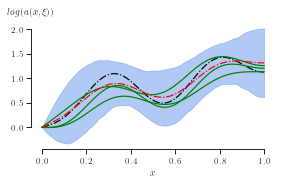

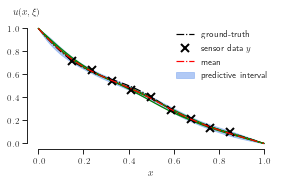

------------------------------------------------------------------------------------------
torch.Size([1000, 5])


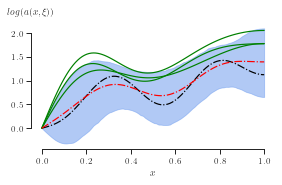

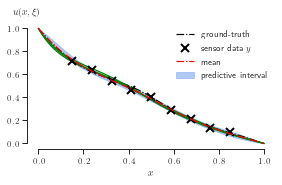

------------------------------------------------------------------------------------------


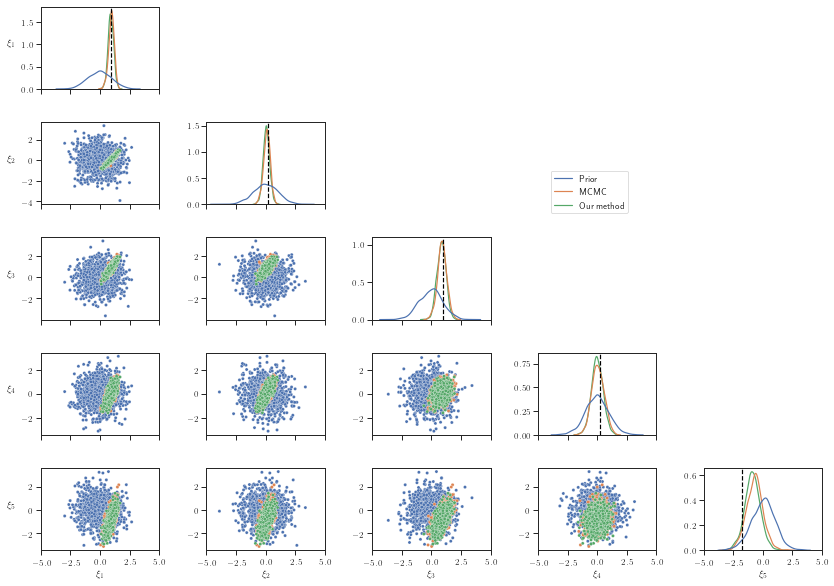

*****************************************************************************************************************************************************************************************
1
Groundtruth:
 xi_data=[[ 1.185468    1.4125743   0.16325866 -1.7672827  -1.3445061 ]],
 y_data=[[0.6179939  0.48710236 0.44695854 0.4260288  0.40434894 0.32878044
  0.29350793 0.19844048 0.10305757]]
torch.Size([1000, 5])


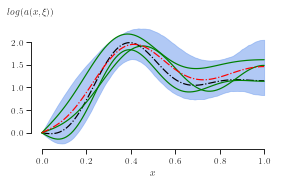

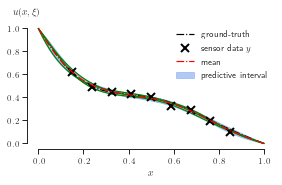

------------------------------------------------------------------------------------------
torch.Size([1000, 5])


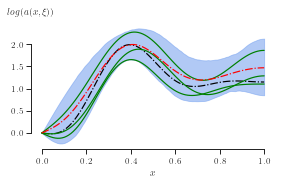

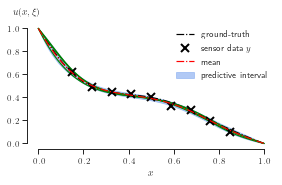

------------------------------------------------------------------------------------------


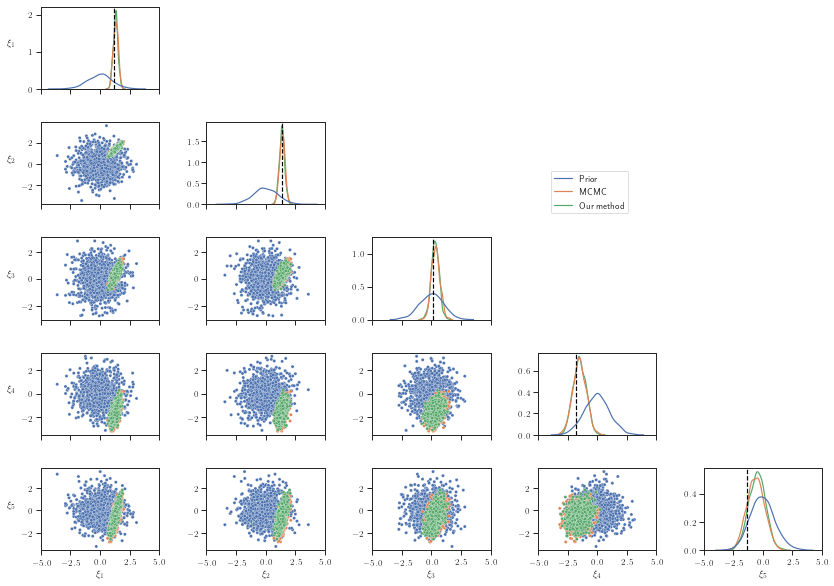

*****************************************************************************************************************************************************************************************
19
Groundtruth:
 xi_data=[[ 0.2019705 -0.4955786  1.9355187  2.110527   1.0979635]],
 y_data=[[0.9067436  0.8522285  0.76024973 0.63854253 0.45978564 0.3296085
  0.2112838  0.1397417  0.10639258]]
torch.Size([1000, 5])


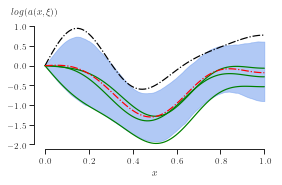

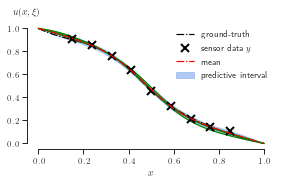

------------------------------------------------------------------------------------------
torch.Size([1000, 5])


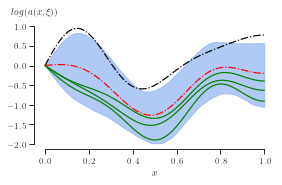

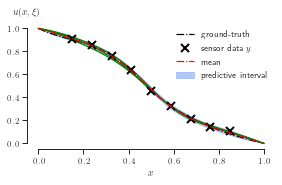

------------------------------------------------------------------------------------------


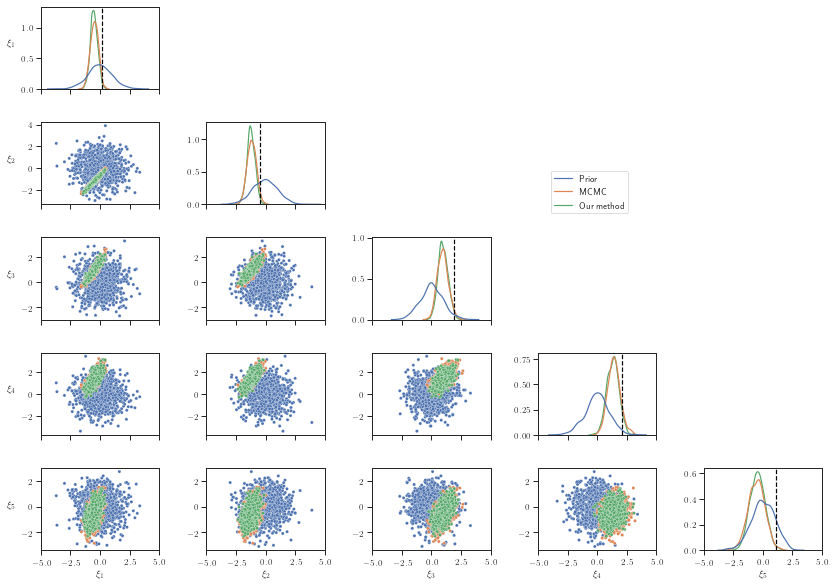

*****************************************************************************************************************************************************************************************
18
Groundtruth:
 xi_data=[[-1.4329859   0.3829131   0.05949217 -1.8187182  -0.6335351 ]],
 y_data=[[0.9334481  0.8960928  0.88121146 0.8447143  0.7858739  0.72330076
  0.5816617  0.39873368 0.25093988]]
torch.Size([1000, 5])


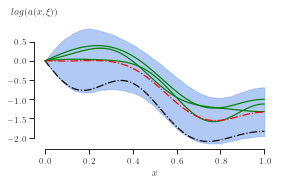

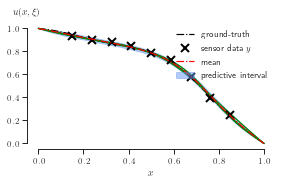

------------------------------------------------------------------------------------------
torch.Size([1000, 5])


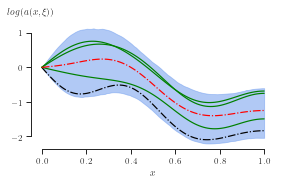

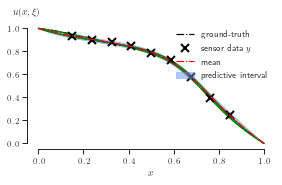

------------------------------------------------------------------------------------------


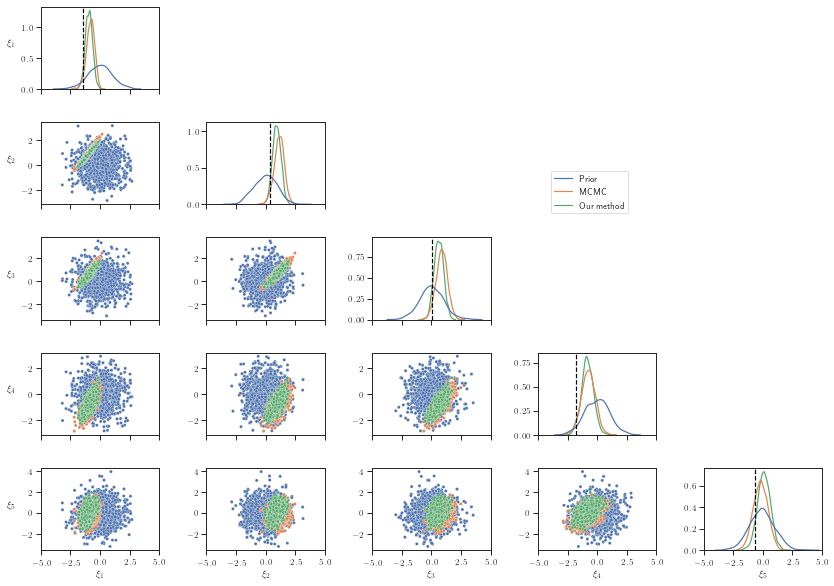

*****************************************************************************************************************************************************************************************
9
Groundtruth:
 xi_data=[[-0.7701383   1.5392127   0.03044852  0.5329035   0.5738441 ]],
 y_data=[[0.96356034 0.92440265 0.8868768  0.84074473 0.81935394 0.74075836
  0.65002877 0.5198854  0.34817848]]
torch.Size([1000, 5])


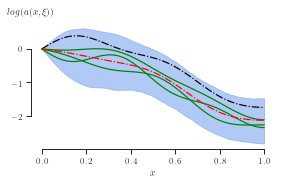

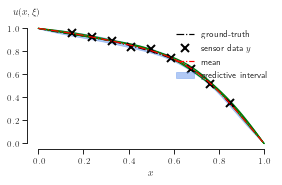

------------------------------------------------------------------------------------------
torch.Size([1000, 5])


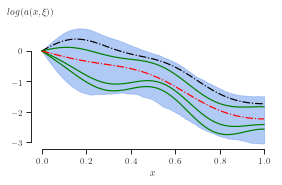

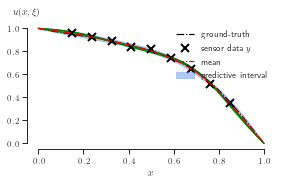

------------------------------------------------------------------------------------------


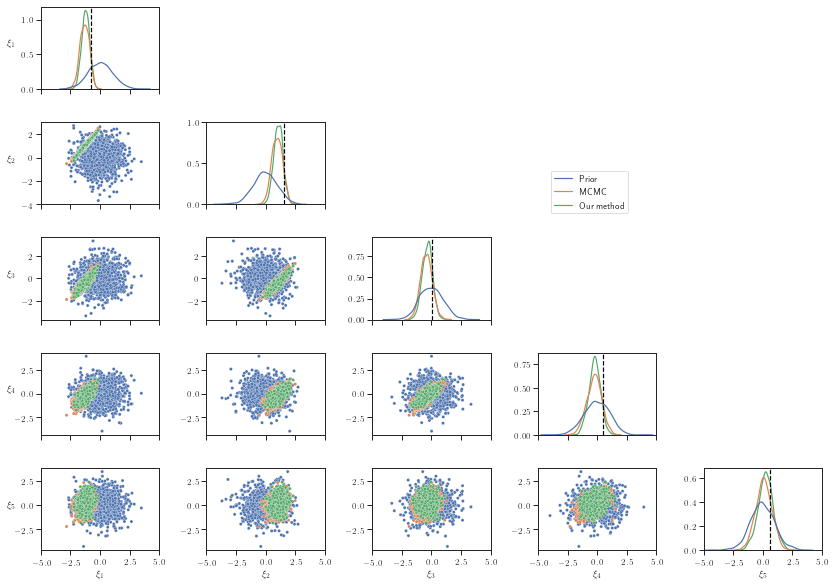

*****************************************************************************************************************************************************************************************
11
Groundtruth:
 xi_data=[[ 0.4499938  -1.3973818  -0.51734835  0.29636776 -0.6820383 ]],
 y_data=[[0.7737652  0.6496034  0.48081788 0.3711717  0.29878244 0.19876975
  0.136425   0.09877858 0.06010424]]
torch.Size([1000, 5])


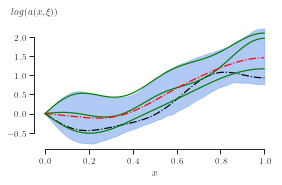

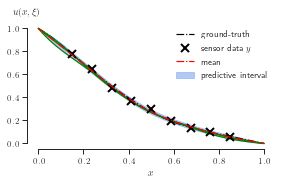

------------------------------------------------------------------------------------------
torch.Size([1000, 5])


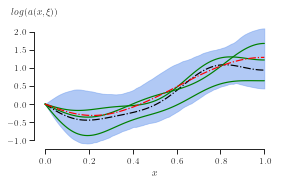

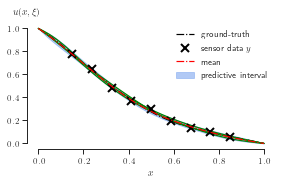

------------------------------------------------------------------------------------------


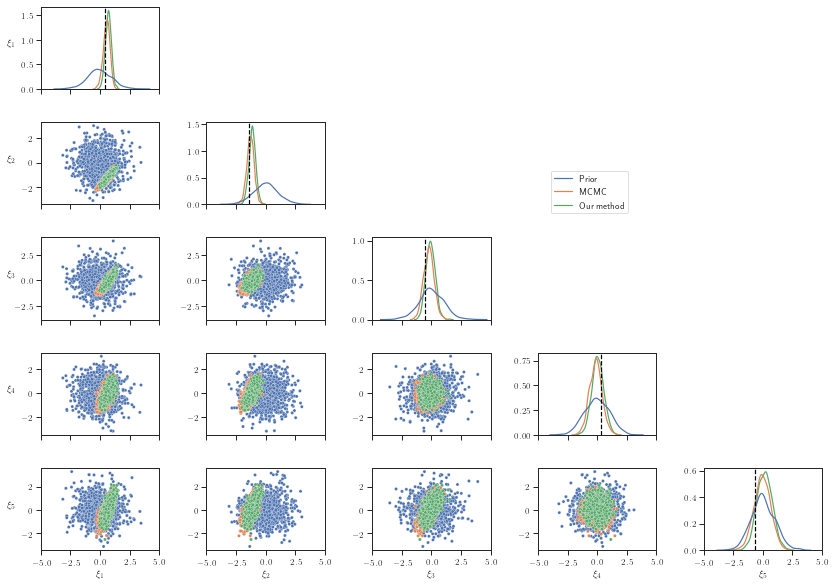

*****************************************************************************************************************************************************************************************


In [6]:
n_samples = 1000 # number of posterior samples

for j in [6,1,19,18,9,11]: 
    print(j)
    
    # Getting data
    xi_data, y_data = xi_data_[j].reshape(1,-1), y_data_[j].reshape(1,-1)
    print('Groundtruth:\n xi_data='+str(xi_data.data.numpy())+',\n y_data='+str(y_data.data.numpy()))
    
    # print(str(j)+'_AVI')
    # AVI_Full-rank-Gaussian
    xi_samples_AVI = torch.load(results_dir +str(j)+'_AVI'+'_xi_samples.pt')
    print(xi_samples_AVI.shape)
    plot(xi_samples_AVI, xi_data, y_data, str(j)+'_AVI', "Our method (Full-rank Gaussian)") 
    print('-'*90)

    # print(str(j)+'_MCMC')
    # MCMC
    xi_samples_MCMC = torch.load(results_dir +str(j)+'_MCMC'+'_xi_samples.pt')
    print(xi_samples_MCMC.shape)
    plot(xi_samples_MCMC, xi_data, y_data, str(j)+'_MCMC', "MCMC (NUTS)")
    print('-'*90)    
    
    ######
    Prior_data = prior_xi_dist.sample([n_samples]).T.data.numpy()
    Prior_dict = dict() 
    for i in range(Prior_data.shape[0]):
        Prior_dict[r'$\xi_{%.0f}$' % (i+1)] = Prior_data[i] 

    AVI_data = xi_samples_AVI.T.data.numpy()
    AVI_dict = dict() 
    for i in range(AVI_data.shape[0]):
        AVI_dict[r'$\xi_{%.0f}$' % (i+1)] = AVI_data[i]  

    MCMC_data = xi_samples_MCMC.T.data.numpy()
    MCMC_dict = dict() 
    for i in range(MCMC_data.shape[0]):
        MCMC_dict[r'$\xi_{%.0f}$' % (i+1)] = MCMC_data[i]    

    df_Prior = pd.DataFrame(Prior_dict)
    df_MCMC = pd.DataFrame(MCMC_dict)
    df_AVI = pd.DataFrame(AVI_dict)
    df_Prior['Sample type'] = 'Prior'
    df_MCMC['Sample type'] = 'MCMC'
    df_AVI['Sample type'] = 'Our method'

    df = pd.concat([df_Prior, df_MCMC, df_AVI])
    df.reset_index(drop=True, inplace=True)
    pair_plot(df, xi_data, j)
    ######   
    
    print('*'*185)  